Lastest version arraymap with mecan
Use data from oringal file instead of db

In [1]:
from pymongo import MongoClient
import sys, os
import mecan4cna.algorithms as alg
import operator
from natsort import natsorted 

In [2]:

def file2list(fin):
    ls = []

    next(fin)
    for line in fin:
        line = line.split()
        try:
            ls.append({'chro':str(line[1]), 'start':int(line[2]), 'end':int(line[3]), 'probes':int(float(line[5])),'value':float(line[4])})
        except Exception as e:
            print('Skip line: {}\t{}'.format(line[0], e))
            continue
    return ls

In [4]:
arraymap_data = []
db_am_bs = MongoClient()['arraymap_ga4gh']['biosamples']
db_am_ind = MongoClient()['arraymap_ga4gh']['individuals']
db_am_cs = MongoClient()['arraymap_ga4gh']['callsets']
db_am_var = MongoClient()['arraymap_ga4gh']['variants']

for sample in db_am_bs.find():
    bs_id = sample['id']
    ind_id = sample['individual_id']
    project = sample['project_id']
    morphology = sample['biocharacteristics'][1]['type']['id']

    if morphology in ['icdom-00000', 'icdom-']:
        continue

    topography = sample['biocharacteristics'][0]['type']['id']
    try:
        stage = sample['info']['tnm']
    except:
        stage = None

    ind = db_am_ind.find_one({'id': ind_id})
    gender = ind['biocharacteristics'][0]['description']

    age = sample['age_at_collection']['age']
    vital_status = sample['info']['death']

    cs = db_am_cs.find_one({'biosample_id': bs_id})
    
    try:
        file_path = cs['info']['paths']['segmentfile']
    except:
        continue
        
    platform = cs['description']

    segments = []
    

    arraymap_data.append({'source': 'arraymap',
                          'project': project,
                          'sample_id': bs_id,
                          'morphology': morphology,
                          'topography': topography,
                          'stage': stage,
                          'gender': gender,
                          'age': age,
                          'vital_status': vital_status,
                          'file_path': file_path,
                          'platform': platform})


In [5]:
data = arraymap_data

In [ ]:
for sample in data:
    uid = sample['sample_id'].split('_')[-1]
    sid = sample['project']
    fpath = os.path.join('/Volumes/arraymap/grch38', sid, uid, 'segments,cn.tsv')
    
    try:
        with open(fpath, 'r') as fin:
            sample['segments'] = file2list(fin)
    except Exception as e:
        sample['segments'] = None
        print('Skip sample: {}\t{}'.format(bs_id, e))
        continue

In [ ]:
c = 0
m = alg.mecan()
for sample in data:
#     if 'base' not in sample.keys():
    c += 1
    try:
        if 'snp 6' in sample['platform']:
            m.peak_thresh=5000
        elif '250k' in sample['platform']:
            m.peak_thresh=2000
        else: 
            m.peak_thresh=1000

        res = m.run(sample['segments'])
        if len(res) > 1:
            base = res[0]
            level_dist = res[1]
        else:
            base = None
            level_dist = None
    except Exception as e:
        print('Skip sample: {}\t{}'.format(bs_id, e))
        base = None
        level_dist = None

    sample['base'] = base
    sample['level_distance'] = level_dist

    print(c, end='\r')


In [25]:
print(len(data))
c = 0
for sample in data:
    if sample['base'] == None:
        c += 1
print(c)

52072
16002


In [8]:
data_write = []
for sample in data:
    if sample['base'] != None:
        data_write.append(sample)


In [9]:
len(data_write)

31805

In [11]:
db = MongoClient()['Rebased']['arraymap']
db.drop()
db.insert_many(data_write)

In [10]:
len(data)

52072

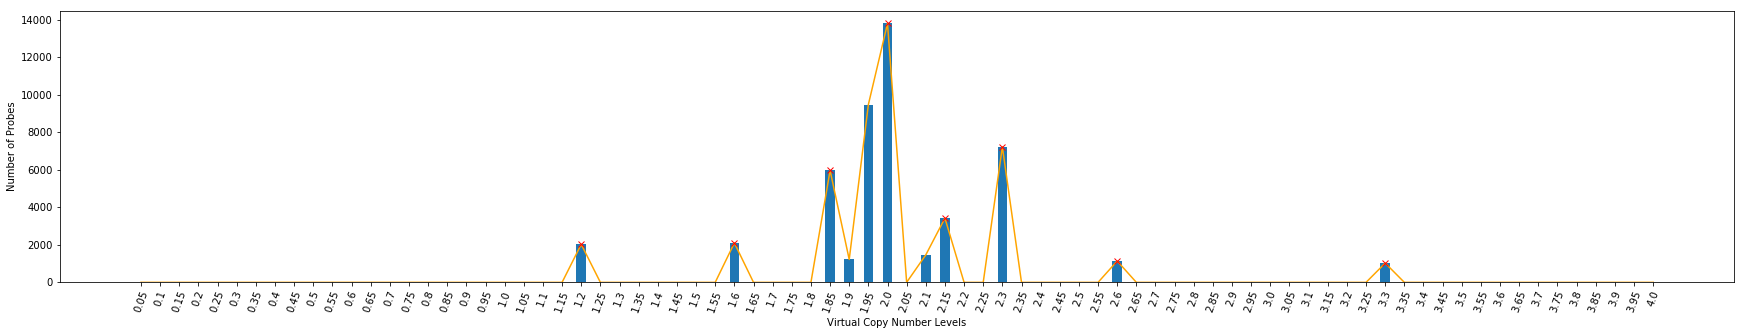

(2.0,
 1.3,
        score  neglects  base_bin  thresh_bin  base_value  thresh_value  \
 0   0.343043    5267.0      3.30        2.00        1026         13798   
 1   0.343043    5267.0      2.00        3.30       13798          1026   
 2   0.442397    5965.0      2.00        1.60       13798          2101   
 3   0.442397    5965.0      1.60        2.00        2101         13798   
 4   0.463472    3422.0      2.30        2.60        7224          1137   
 5   0.463472    3422.0      2.60        2.30        1137          7224   
 6   0.447966    2101.0      1.20        2.00        2029         13798   
 7   0.447966    2101.0      2.00        1.20       13798          2029   
 8   0.440687    3238.0      2.15        3.30        3422          1026   
 9   0.440687    3238.0      3.30        2.15        1026          3422   
 10  0.446720       0.0      1.20        1.60        2029          2101   
 11  0.446720       0.0      1.60        1.20        2101          2029   
 12  0.500405

In [23]:
m.showplot = True
m.run(data[100]['segments'])

In [19]:
td = data_write[10]
fpath = os.path.join('/Volumes/arraymap/grch38', td['project'], td['sample_id'].split('_')[-1], 'segments,cn.tsv')
with open(fpath, 'r') as fin:
            td['segments'] = file2list(fin)

In [31]:
c = 0
delete_list = []
for sample in data:
    if sample['segments'] == None:
        delete_list.append(sample['sample_id'])
        c += 1
print(c)

7068


In [32]:
c = 0
for sample in db.find({'sample_id':{'$in': delete_list}}):
    c +=1
print(c)

4265


In [35]:
db.count()

36070

In [36]:
db.delete_many({'sample_id':{'$in': delete_list}})

In [37]:
db.count()

31805